# Time lapse imaging analysis with `byc`

# 3. Segment cells and measure fluorescence using annotation data
See `byc` README.md for steps leading up to this segmentation step

In [1]:
import os
import re
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

from byc import constants, files, database, segmentation, utilities, trace_tools
from byc import standard_analysis as sa
from byc import plotting
from byc import fitting_tools as ft

from importlib import reload

for mod in [
    constants,
    files,
    database,
    segmentation,
    utilities,
    trace_tools
]:
    reload(mod)
plotting.set_styles(plt, matplotlib)

## Define the experiment and compartment you want to analyze

In [2]:
compartmentname = "20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr"
collection_interval_minutes = 10
exptname = utilities.exptname_from_compartment(compartmentname)
compartmentdir = files.get_byc_compartmentdir(exptname, compartmentname)
channels_list = utilities.check_compartmentdir_for_channels(compartmentdir)
channels = ' '.join(channels_list)
# Check that there are crop and bud roi dfs, which contain
# annotated information about the .zip roi files, for all the cells in the dataset
utilities.check_bud_and_crop_roi_dfs(compartmentdir)
mdf = utilities.generate_mdf(exptname, compartmentname, channels=channels_list)
filename = f'{compartmentname}_alldf_measured.csv.gzip'
allmeasuredpath = os.path.join(compartmentdir, filename)

Missing crop df .csv files for cells []
Missing bud df .csv files for cells []
Adding paths for channels ['bf', 'yfp']


## 3. Segment cell areas using option a or b below

### 3a. Segment cell areas with brightfield data using a radial intensity peak-based segmentation method implemented in the `byc` script `segment_byc_dataset`

Usually this is done in budding yeast datasets where we are measuring dynamics of a fluorescent signal and don't have a fluorophore we can use for segmentation

In [3]:
script_path = os.path.join(constants.source_path, 'bin/segment_byc_dataset.py')
%run $script_path $compartmentname "bf yfp"

### 3b. Segment cell areas with fluorescence data using otsu thresholding

Most experiments are run without a fluorophore expressed that's suitable for use in segmenting cell areas, so typically we use the above radial intensity trace segmentation method on brightfield data. But there are some experiments where the 

In [ ]:
mdf = utilities.generate_mdf(exptname, compartmentname, channels=channels_list)
# Create cell crop stack files
segmentation.write_cell_crop_stacks(mdf, return_cellstacks_dict=False)
segkwargs = {
    'collection_interval_minutes': 10,
    'maskpath_suffix': 'nucleus',
    'channel_to_segment': 'gfp',
    'channels_to_measure': ['gfp'],
    'var_to_exclude_rois': 'major_axis_length',
    'set_outliers_to_nan': True
}
celldfs = segmentation.segment_and_measure_byc_dataset(mdf[0:5], **segkwargs)
# Further processing and annotation of fluorescence traces
# Includes features like cell cycle duration and number of cell divisions before death
segmentation.refine_and_annotate_celldfs(celldfs, mdf,
    collection_interval_minutes=10,
    channels_to_normalize=['gfp'],
    yvars=['mean'],
    channel_auto_fluors=[155]
    )
tracesavepath = os.path.join(mdf.loc[0, 'compartment_dir'], f'{exptname}_alldf.csv')
alldf = pd.concat(celldfs)
alldf.index = range(len(alldf))
alldf.to_csv(tracesavepath, index=False)
print(f'Saved traces df at\n{tracesavepath}')

## 4. Read in the measurements dataframe created using one of the segmentation methods above

### Read in segmentation data created using radial intensity method and save cell outlines as binary masks
This includes the option to smooth radial intensity-generated cell area masks into ellipses

In [3]:
%%capture smoothing_output
smooth_ROIs_to_ellipse = True
mdf = utilities.generate_mdf(exptname, compartmentname)
# get_cell_trace_dfs_from_outline_vertices will create binary
# masks stack .tifs as well as measuring fluorescence using
# those masks
celltracedfs = segmentation.get_cell_trace_dfs_from_outline_vertices(
    mdf,
    collection_interval_minutes=collection_interval_minutes,
    save_mask_stack=True,
    outline_file_keyword = 'outline-vertices.csv'
)
# Read in the binary mask stacks created above and smooth
# them into ellipses. Saves smoothed data as outline vertices
# .csv files and as binary mask stacks
if smooth_ROIs_to_ellipse:
    for cell_index in mdf.cell_index.unique():
        segmentation.smooth_masks_with_ellipse(
            mdf,
            cell_index,
            plot_visualization=False)
    # Use the smoothed ellipse cell outlines to read in 
    # fluorescence traces
    celltracedfs = segmentation.get_cell_trace_dfs_from_outline_vertices(
        mdf,
        collection_interval_minutes=collection_interval_minutes,
        save_mask_stack=False,
        outline_file_keyword='outline-vertices-ellipse.csv'
    )
else:
    pass

filename = f'{exptname}_alldf.csv'
tracesavepath = os.path.join(compartmentdir, filename)
traces_df = pd.concat(celltracedfs, ignore_index=True)
traces_df.to_csv(tracesavepath, index=False)
print(f'Saved all cell traces df at\n{tracesavepath}')

### Read in table of on record per frame per cell and annotate it

In [4]:
%%capture readin_output
filename = f'{exptname}_alldf.csv'
tracesavepath = os.path.join(compartmentdir, filename)
table = pd.read_csv(tracesavepath)
# Annotate all information found in the master index dataframe
# into the compartment table
for col in mdf.columns:
    if col not in table.columns:
        for cell_index in mdf.cell_index.unique():
            val = mdf.loc[cell_index, col]
            table.loc[table.cell_index==cell_index, col] = val
table.loc[:, 'hours_rel'] = table.frame*(10/60)
table.loc[:, 'frame_number'] = table.frame
table.loc[:, 'exptname'] = exptname
table.loc[:, 'compartment_reldir'] = mdf.loc[0, 'compartment_reldir']
cols = [
        'end_event_type',
        'contains_aggregate'
    ]
for col in cols:
    for cell_index in table.cell_index.unique():
        table.loc[table.cell_index==cell_index, col] = mdf.loc[mdf.cell_index==cell_index, col].iloc[0]
# Compensate for YFP fluor bleedthrough to RFP filter cube
if 'rfp_mean' in table.columns:
    table.loc[:, 'rfp_mean_compensated'] = table.rfp_mean - table.yfp_mean*0.04

celldfs = [table[table.cell_index==i] for i in table.cell_index.unique()]
for df in celldfs:
    df.index = range(len(df))
    
# Further annotation
for df in celldfs:
    df.loc[:, 'compartment_reldir'] = mdf.compartment_reldir.iloc[0]
segmentation.refine_and_annotate_celldfs(celldfs, mdf,
    collection_interval_minutes=10,
    channels_to_normalize=channels_list,
    yvars=['mean'],
    channel_auto_fluors=[117, 136]
    )

alldf = pd.concat(celldfs)
alldf.index = range(len(alldf))
alldf.to_csv(tracesavepath, index=False)
print(f'Saved traces df at\n{tracesavepath}')

## 5. Detect exponential decay start frame

### Scan chase fit start frames to find an average for each crop start frame

In [6]:
scandfs = []
print('Scan for crops starting at')
for val in alldf.first_crop_frame.sort_values(ascending=True).unique():
    print(f'{val} with {alldf[alldf.first_crop_frame==val].cell_index.nunique()} cells')

Scan for crops starting at
0 with 94 cells
1 with 1 cells
139 with 63 cells


In [44]:
first_crop_frame = 0

kwargs = {
    'xmin': 0,
    'xmax': 12
}

scandfs = []
for tracedf in celldfs:
    if tracedf.first_crop_frame.iloc[0] == first_crop_frame:
        print(f'Scanning fit start frames for cell {tracedf.cell_index.iloc[0]}')

        scandf = ft.scan_start_frames(tracedf,
                                      col_name='yfp_mean',
                                      xvar='frame',
                                      **kwargs)
        scandfs.append(scandf)
allscandf = pd.concat(scandfs, sort=False)
allscandf.loc[:, 'first_crop_frame'] = first_crop_frame
scandfs.append(allscandf)

Scanning fit start frames for cell 0
Length of y_raw = 31
Using background val: 120.95505617977528
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 119.53333333333332
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 119.53333333333332
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 119.53333333333332
Length of y_raw = 31. Length of y_

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Found 13 fit_results
Scanning fit start frames for cell 20
Length of y_raw = 31
Using background val: 125.8976377952756
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 125.8976377952756
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 125.8976377952756
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 125.8976377952756
Length of y_raw 

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-pack

Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 117.4
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 117.4
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 117.4
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using bac

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit cell with cell_index=98
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Length of y_raw = 31
Using background val: 118.44654088050316
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.44654088050316
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Could not fit cell with cell_index=98
Error: array must not contain infs or NaNs
Length of y_raw = 31
Using background val: 118.51270207852194
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.51270207852194
Len

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scanning fit start frames for cell 99
Length of y_raw = 31
Using background val: 119.72303206997084
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 119.72303206997084
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 119.72303206997084
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 119.27272727272728
Length of y_raw = 31. Length of y

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.16998191681736
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.16998191681736
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Could not fit cell with cell_index=100
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Length of y_raw = 31
Using background val: 118.16998191681736
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Could not fit cell with cell_index=100
Error: array must not contain infs or NaNs
Length of y_raw = 31
Using background val: 118.36147757255937
L

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scanning fit start frames for cell 102
Length of y_raw = 31
Using background val: 117.75062344139651
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 117.75062344139651
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 117.75062344139651
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 117.75062344139651
Length of y_raw = 31. Length of 

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Length of y_raw = 31
Using background val: 118.5574162679426
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.5574162679426
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.5574162679426
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.5574162679426
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y 

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Scanning fit start frames for cell 133
Length of y_raw = 31
Using background val: 116.04910714285714
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Could not fit cell with cell_index=133
Error: array must not contain infs or NaNs
Length of y_raw = 31
Using background val: 118.59831460674155
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.59831460674155
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.59831460674155
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calcula

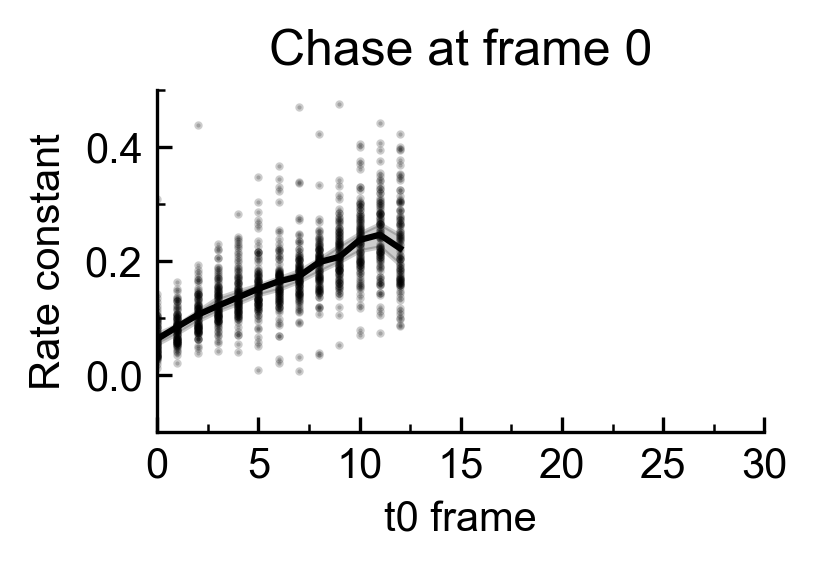

In [45]:
allscandf.index = range(len(allscandf))
scandf = allscandf
yvar = 'b'
ylabel = 'Rate constant'
fig = plt.figure(figsize=(5, 2)) 
fig.set_dpi(300)
xlim = (0, 30)
ylim = (-0.1, 0.5)
size=1
color = 'black'
ax = fig.add_subplot(121)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.scatter(allscandf.start_frame, allscandf[yvar], s=size, color=color, alpha=0.2)
sns.lineplot(x='start_frame', y=yvar, data=allscandf,
             color='black', estimator=np.median, ax=ax)
ax.set_title(f'Chase at frame {first_crop_frame}')


for a in [ax]:
    a.set_ylabel(ylabel)
    a.set_xticks(np.arange(0, np.max(xlim)+1, 5))
    a.set_xlabel('t0 frame')    
    
plotting.format_ticks(ax)
plotting.remove_spines(ax)

plt.tight_layout()

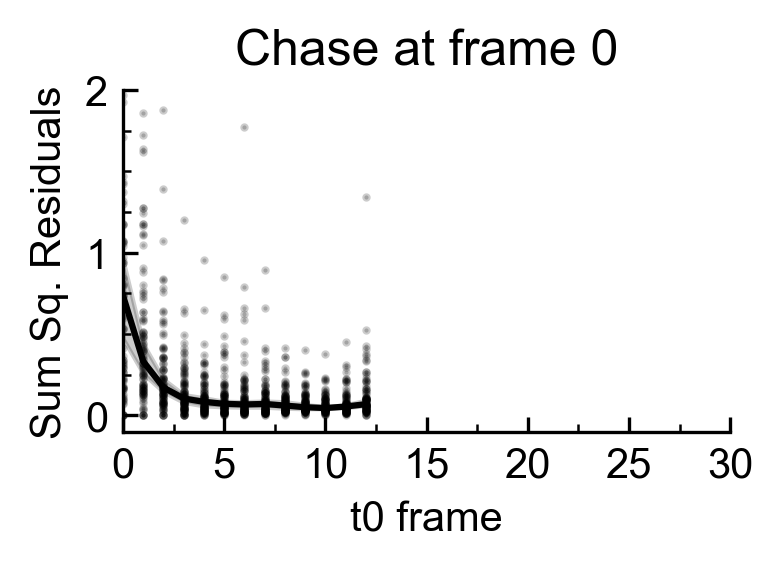

In [46]:
allscandf.index = range(len(allscandf))
scandf = allscandf
yvar = 'ss_residuals'
ylabel = 'Sum Sq. Residuals'
fig = plt.figure(figsize=(5, 2)) 
fig.set_dpi(300)
xlim = (0, 30)
ylim = (-0.1, 2)
size=1
color = 'black'
ax = fig.add_subplot(121)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.scatter(allscandf.start_frame, allscandf[yvar], s=size, color=color, alpha=0.2)
sns.lineplot(x='start_frame', y=yvar, data=allscandf,
             color='black', estimator=np.median, ax=ax)
ax.set_title(f'Chase at frame {first_crop_frame}')


for a in [ax]:
    a.set_ylabel(ylabel)
    a.set_xticks(np.arange(0, np.max(xlim)+1, 5))
    a.set_xlabel('t0 frame')    
    
plotting.format_ticks(ax)
plotting.remove_spines(ax)

plt.tight_layout()

In [47]:
allscandf.pivot_table(index=['start_frame', 'first_crop_frame'], aggfunc=np.median).loc[:, ['ss_residuals']]

ss_residuals
start_frame first_crop_frame              
0           0.0                   0.737039
1           0.0                   0.332303
2           0.0                   0.172055
3           0.0                   0.104218
4           0.0                   0.083736
5           0.0                   0.071808
6           0.0                   0.067730
7           0.0                   0.070937
8           0.0                   0.060727
9           0.0                   0.050795
10          0.0                   0.045618
11          0.0                   0.054768
12          0.0                   0.069565

In [48]:
first_crop_frame = 139

kwargs = {
    'xmin': 0,
    'xmax': 16
}

scandfs = []
for tracedf in celldfs:
    if tracedf.first_crop_frame.iloc[0] == first_crop_frame:
        print(f'Scanning fit start frames for cell {tracedf.cell_index.iloc[0]}')

        scandf = ft.scan_start_frames(tracedf,
                                      col_name='yfp_mean',
                                      xvar='frame',
                                      **kwargs)
        scandfs.append(scandf)
allscandf = pd.concat(scandfs, sort=False)
allscandf.loc[:, 'first_crop_frame'] = first_crop_frame
scandfs.append(allscandf)

Scanning fit start frames for cell 4
Length of y_raw = 31
Using background val: 118.00211416490488
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.00211416490488
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 118.00211416490488
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 117.88008565310491
Length of y_raw = 31. Length of y_

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Calculating resids
Length of y_input 3. Length of y_pred 3
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 2
Using background val: 121.3448753462604
Length of y_raw = 2. Length of y_norm = 2
Fitting with x length 2 and y length 2
Could not fit cell with cell_index=6
Error: The number of func parameters=3 must not exceed the number of data points=2
Length of y_raw = 1
Using background val: 121.3448753462604
Length of y_raw = 1. Length of y_norm = 1
Fitting with x length 1 and y length 1
Could not fit cell with cell_index=6
Error: array must not contain infs or NaNs
Found 16 fit_results
Scanning fit start frames for cell 12
Length of y_raw = 31
Using background val: 120.4375
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Could not fit cell with cell_index=12
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Length of y_raw = 31
Using background val: 120.4375
L

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Calculating resids
Length of y_input 18. Length of y_pred 18
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 17
Using background val: 120.43868739205529
Length of y_raw = 17. Length of y_norm = 17
Fitting with x length 17 and y length 17
Could not fit cell with cell_index=44
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Length of y_raw = 16
Using background val: 120.43868739205529
Length of y_raw = 16. Length of y_norm = 16
Fitting with x length 16 and y length 16
Could not fit cell with cell_index=44
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Length of y_raw = 15
Using background val: 120.43868739205529
Length of y_raw = 15. Length of y_norm = 15
Fitting with x length 15 and y length 15
Could not fit cell with cell_index=44
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Length of y_raw = 14
Using bac

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Length of y_raw = 31
Using background val: 117.4890350877193
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 117.34463276836158
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 116.92252252252251
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using background val: 116.92252252252251
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Length of y_raw = 31
Using background val: 120.64322916666669
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 30
Using background val: 120.44416243654824
Length of y_raw = 30. Length of y_norm = 30
Fitting with x length 30 and y length 30
Calculating resids
Length of y_input 30. Length of y_pred 30
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Found 17 fit_results
Scanning fit start frames for cell 128
Length of y_raw = 31
Using background val: 120.51028037383178
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Could not fit cell with cell_index=128
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Length of y_raw = 31
Using background val: 120.51028037383178
Length of y_raw = 31. L

C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\johnp\Dropbox\Projects\venvs\.byc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Could not fit cell with cell_index=142
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Length of y_raw = 31
Using background val: 123.00904977375566
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Could not fit cell with cell_index=142
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Length of y_raw = 31
Using background val: 123.00904977375566
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Could not fit cell with cell_index=142
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Length of y_raw = 31
Using background val: 123.00904977375566
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Length of y_raw = 31
Using 

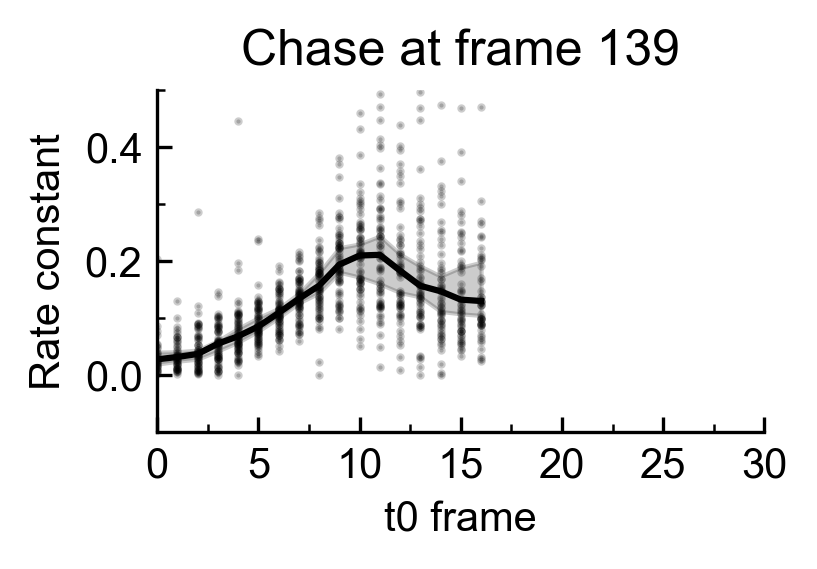

In [49]:
allscandf.index = range(len(allscandf))
scandf = allscandf
yvar = 'b'
ylabel = 'Rate constant'
fig = plt.figure(figsize=(5, 2)) 
fig.set_dpi(300)
xlim = (0, 30)
ylim = (-0.1, 0.5)
size=1
color = 'black'
ax = fig.add_subplot(121)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.scatter(allscandf.start_frame, allscandf[yvar], s=size, color=color, alpha=0.2)
sns.lineplot(x='start_frame', y=yvar, data=allscandf,
             color='black', estimator=np.median, ax=ax)
ax.set_title(f'Chase at frame {first_crop_frame}')


for a in [ax]:
    a.set_ylabel(ylabel)
    a.set_xticks(np.arange(0, np.max(xlim)+1, 5))
    a.set_xlabel('t0 frame')    
    
plotting.format_ticks(ax)
plotting.remove_spines(ax)

plt.tight_layout()

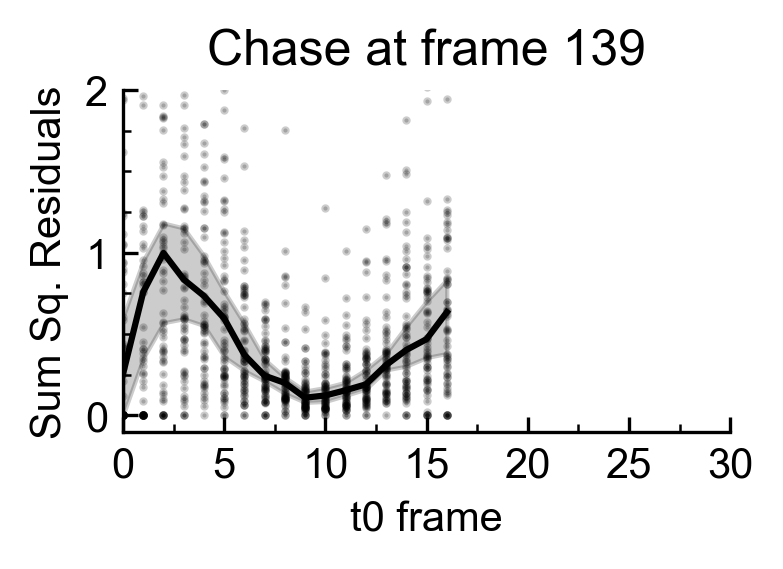

In [50]:
allscandf.index = range(len(allscandf))
scandf = allscandf
yvar = 'ss_residuals'
ylabel = 'Sum Sq. Residuals'
fig = plt.figure(figsize=(5, 2)) 
fig.set_dpi(300)
xlim = (0, 30)
ylim = (-0.1, 2)
size=1
color = 'black'
ax = fig.add_subplot(121)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.scatter(allscandf.start_frame, allscandf[yvar], s=size, color=color, alpha=0.2)
sns.lineplot(x='start_frame', y=yvar, data=allscandf,
             color='black', estimator=np.median, ax=ax)
ax.set_title(f'Chase at frame {first_crop_frame}')


for a in [ax]:
    a.set_ylabel(ylabel)
    a.set_xticks(np.arange(0, np.max(xlim)+1, 5))
    a.set_xlabel('t0 frame')    
    
plotting.format_ticks(ax)
plotting.remove_spines(ax)

plt.tight_layout()

In [51]:
allscandf.pivot_table(index=['start_frame', 'first_crop_frame'], aggfunc=np.median).loc[:, ['ss_residuals']]

ss_residuals
start_frame first_crop_frame              
0           139.0                 0.254959
1           139.0                 0.758741
2           139.0                 0.998762
3           139.0                 0.835568
4           139.0                 0.734649
5           139.0                 0.596278
6           139.0                 0.372077
7           139.0                 0.244181
8           139.0                 0.200090
9           139.0                 0.109287
10          139.0                 0.122994
11          139.0                 0.154907
12          139.0                 0.191151
13          139.0                 0.309650
14          139.0                 0.402700
15          139.0                 0.469000
16          139.0                 0.634902

### Plot t0 normalized substrate fluorescence over time for each cell using the t0 chase frames defined above

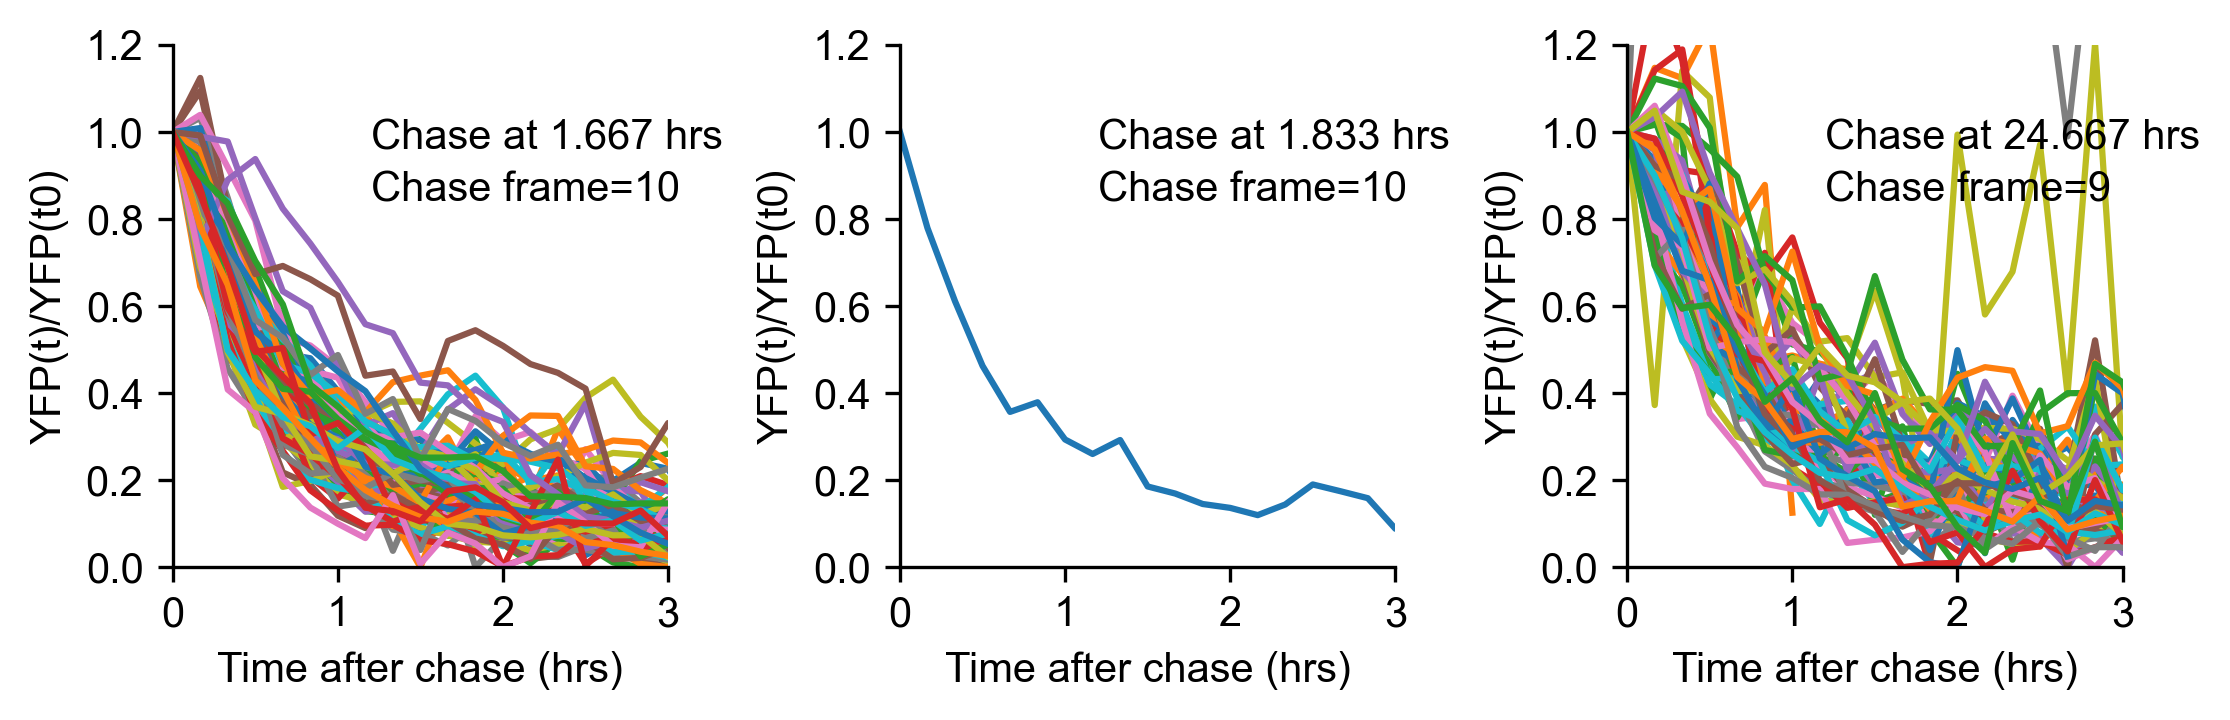

In [55]:
# Concatenate celldfs back together and define 
# a dictionary holding the chase frame (t0 frame)
# for each unique first crop frame
tracesdf = pd.concat(celldfs, sort=False)
crop_starts = np.sort(list(tracesdf.first_crop_frame.unique()))
chase_frames = [10, 10, 9]
chase_frame_dict = dict(zip(list(crop_starts), chase_frames))

table = tracesdf
yvar = 'yfp_mean'
nrows = 1
ncols = len(crop_starts)
height = nrows*2.5
width = ncols*2.5
xlim = (0, 3)
ylim = (0, 1.2)
delta_t = 10
fig = plt.figure(figsize=(width, height))
fig.set_dpi(300)
axes = [fig.add_subplot(nrows, ncols, i+1) for i in range(len(crop_starts))]
axdict = dict(zip(crop_starts, axes))
# Plot each individual cell from each chase
for crop_start in crop_starts:
    ax = axdict[crop_start]
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    chase_frame = chase_frame_dict[crop_start]
    xy = (np.max(xlim)*0.4, np.max(ylim)*0.8)
    xy2 = (xy[0], np.max(ylim)*0.7)
    chase_hours = ((crop_start+chase_frame)*delta_t)/60
    chase_hours = np.round(chase_hours, 3)
    ax.annotate(f'Chase at {chase_hours} hrs', xy=xy)
    ax.annotate(f'Chase frame={chase_frame}', xy=xy2)
    startdf = table[table.first_crop_frame==crop_start]
    for cell_index in startdf.cell_index.unique():
        
        df = startdf[startdf.cell_index==cell_index]
        x = df.sort_values(by='frame').frame[chase_frame:] - chase_frame
        x = (x*delta_t)/60
        y = df.sort_values(by='frame')[yvar][chase_frame:] - df.sort_values(by='frame')[yvar][:].min()
        y = y/y.iloc[0]
        ax.plot(x, y)
        ax.set_ylabel('YFP(t)/YFP(t0)')
        ax.set_xlabel('Time after chase (hrs)')
        plotting.remove_spines(ax)
plt.tight_layout()

### Annotate absolute chase frame and distance from senescence for each chase

In [56]:
# Relabel tracedfs after having determined chase starts above
channels = ['bf', 'yfp']
args = [exptname,
        compartmentname]
kwargs = {'age_state': 'old',
          'chase_frame_dict': chase_frame_dict}

mdf = sa.create_and_annotate_mdf(*args, **kwargs)
# Set chase frames in celldf table according to above
crop_starts = chase_frame_dict.keys()
# For some reason dist_from_sen is getting fucked up so redefine
# it straight from master index df
for cell_index in mdf.cell_index.unique():
    abs_chase_frame = mdf[mdf.cell_index==cell_index].abs_chase_frame.iloc[0]
    dist_from_sen = mdf[mdf.cell_index==cell_index].dist_from_sen.iloc[0]
    table.loc[table.cell_index==cell_index, 'dist_from_sen'] = dist_from_sen
    table.loc[table.cell_index==cell_index, 'abs_chase_frame'] = abs_chase_frame

for crop_start in crop_starts:
    chase_frame = chase_frame_dict[crop_start]
    table.loc[table.first_crop_frame==crop_start, 'chase_frame'] = ckhase_frame
# Add a t0 normalized column to each trace dataframe
tracedfs = [table[table.cell_index==cidx] for cidx in table.cell_index.unique()]
for df in tracedfs:
    df.index = range(len(df))
tracedfs = [sa.t0_normalize_trace_df(tracedf,
                                     yvar='yfp_mean',
                                     norm_col_name='yfp_norm') for tracedf in tracedfs]

Defaulting to channels bf, rfp, yfp
Analyzing channels ['bf', 'yfp', 'rfp']
Found compartment directory:
C:\Users\johnp\Dropbox\Projects\byc\data/20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr
Found 158 potential crop_rois roi df .csv files
Adding relative path to mdf
Saved master index df at:
C:\Users\johnp\Dropbox\Projects\byc\data/20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr_crop_rois.csv
The word data not found in path:
20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr\20230928_byc_xy13_bf_stack.tif
Returning original path because it is probably already relative
The word data not found in path:
20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr\20230928_byc_xy13_bf_stack.tif
Returning original path because it is probably already relative
The word data not found in path:
20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr\20230928_byc_xy13_bf_stack.tif
Returning original pat

C:\Users\johnp\Dropbox\Projects\byc\byc\standard_analysis.py:499: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracedf.sort_values(by='frame', inplace=True)
C:\Users\johnp\Dropbox\Projects\byc\byc\standard_analysis.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracedf.loc[:, f'{yvar}_bg_sub'] = np.nan
C:\Users\johnp\Dropbox\Projects\byc\byc\standard_analysis.py:512: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

### Plot t0 normalized traces with color corresponding to senescence proximity

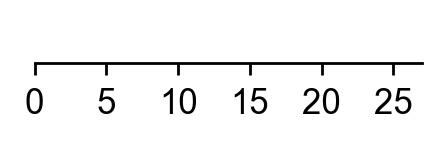

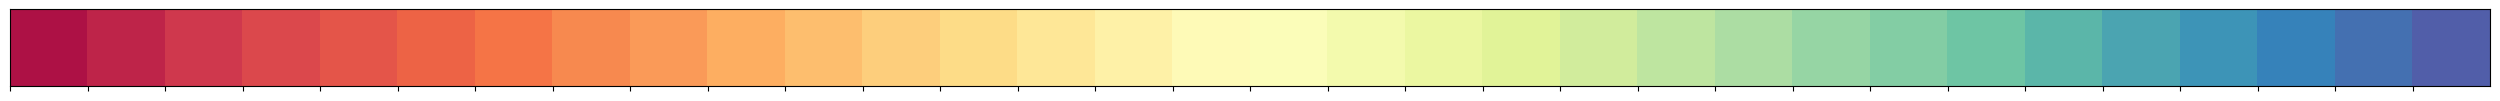

In [57]:
palette = sns.color_palette("Spectral", n_colors=int(np.max(table.dist_from_sen))+1)

fig, ax = plotting.figure_ax(width_scale=1, height_scale=0.1)
ax.set_xlim(0, 27)
ax.set_xticks([0, 5, 10, 15, 20, 25])
ax.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)
plot = sns.palplot(palette)

Saved figure at:
C:\Users\johnp\Dropbox\Projects\byc\data/20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr\Yfp_vs_time_color_dist_from_sen.png


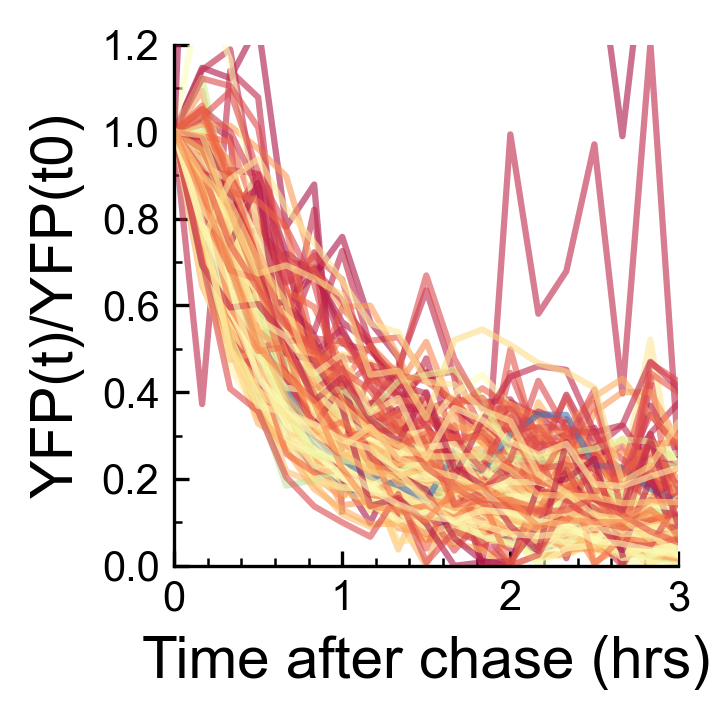

In [58]:
dfs = tracedfs
savefig=True
y_var = 'yfp_norm'
plotkwargs = {'alpha': 0.6,
              'linewidth': 1.5}

ylabel = 'YFP(t)/YFP(t0)'
xlabel = 'Time after chase (hrs)'
compdir = os.path.join(constants.byc_data_dir, mdf.compartment_reldir.unique()[0])
exptdir = os.path.abspath(os.path.join(compdir, '..'))
filetype = '.png'
savepath = os.path.join(compdir, f'Yfp_vs_time_color_dist_from_sen{filetype}')

ylim = (0, 1.2)
xlim = (0, 3)
fig = plt.figure(figsize=(2.5, 2.5))
fig.set_dpi(300)

ax = fig.add_subplot(111)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

colors = sns.color_palette('husl', len(dfs))
for i, df in enumerate(dfs):
    chase_frame = df.chase_frame.unique()[0]
    y = df.loc[chase_frame:, y_var]
    x = [(i*10)/60 for i in range(len(y))]
    dist_from_sen = df.dist_from_sen.iloc[0]
    if not np.isnan(dist_from_sen):
        color =palette[int(dist_from_sen)]
        ax.plot(x, y, color=color, label=f'Cell {i}', **plotkwargs)
    else:
        print(f'Dist from sen is nan for cell {df.cell_index.unique()[0]}')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for spine in [ax.spines[key] for key in ['top', 'right']]:
    spine.set_visible(False)
    
ax.set_ylabel(ylabel, fontsize=14)
ax.set_xlabel(xlabel, fontsize=14)
loc = (0.3*np.max(xlim), 0.9*np.max(ylim))
# ax.annotate(f'Chase frame = {chase_frame}', xy=loc)
plotting.format_ticks(ax, xminorspace=0.2, yminorspace=0.1)
plt.tight_layout()
if savefig:
    fig.savefig(savepath)
    print(f'Saved figure at:\n{savepath}')

### Fit fluorescence traces to exponential decay to derive pseudo first order rate constant

In [59]:
col_name = 'yfp_mean'
fits_df = ft.get_all_fits_df(tracedfs, None, 18, col_name=col_name)
# Get rid of failed fit data
fits_df = fits_df[fits_df.b.isna() == False]

Fitting cell with index 0
Got start frame from trace dataframe
Using start frame 10 for fit
Length of y_raw = 19
Using background val: 119.53333333333332
Length of y_raw = 19. Length of y_norm = 19
Fitting with x length 19 and y length 19
Calculating resids
Length of y_input 19. Length of y_pred 19
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Fitting cell with index 1
Got start frame from trace dataframe
Using start frame 10 for fit
Length of y_raw = 19
Using background val: 119.26075268817203
Length of y_raw = 19. Length of y_norm = 19
Fitting with x length 19 and y length 19
Calculating resids
Length of y_input 19. Length of y_pred 19
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Fitting cell with index 2
Got start frame from trace dataframe
Using start frame 10 for fit
Length of y_raw = 19
Using background val: 121.05379746835445
Length of y_raw = 19. Length of y_norm = 19
Fitting with x length 19 and y length 19

### For each cell, scatter plot fluorescence vs time after chase and line plot the fit so they can be visually inspected

In [60]:
filename = 'all_cell_fits.svg'
compdir = os.path.join(constants.byc_data_dir, mdf.compartment_reldir.iloc[0])
savepath = os.path.join(compdir, filename)

fits_df.sort_values(by='cell_index', inplace=True)
nrows = 37
ncols = 6
fig = plt.figure(figsize=(ncols*2.4, nrows*2.4))
fig.set_dpi(300)
i=1
xlim = (0, 3)
ylim = (0, 1.2)
for cell_index in fits_df.cell_index.unique():
    df = fits_df[fits_df.cell_index==cell_index]
    dist_from_sen = df.dist_from_sen.unique()[0]
    rate = np.round(df.b.unique()[0], 3)
    ax = fig.add_subplot(nrows, ncols, i)
    sns.scatterplot(x='x_input', y='y_input_norm', color='black',
                    data=df, ax=ax)
    sns.lineplot(x='x_input', y='y_pred_norm', color='black',
                 data=df, ax=ax)
    
    ax.set_title(f'Cell{cell_index}')
   
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    shapiro_p = df.shapiro_p.iloc[0]
    shapiro_p_round = np.round(shapiro_p, 3)
    xy = (0.5, np.max(ylim)*0.8)
    xyrate = (0.5, np.max(ylim)*0.7)
    xyabschase = (0.5, np.max(ylim)*0.6)
    if shapiro_p < 0.05:
        color= 'red'
    else:
        color='black'
    ax.annotate(f'Shapiro p={shapiro_p_round}', xy=xy, color=color)
    ax.annotate(f'Rate={rate}', xy=xyrate)
    ax.annotate(f'Abs chase frame={int(df.abs_chase_frame.iloc[0])}', xy=xyabschase)
    i+=1
plt.tight_layout()
fig.savefig(savepath)
print(f'Figure saved at\n{savepath}')

Figure saved at
C:\Users\johnp\Dropbox\Projects\byc\data/20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr\all_cell_fits.svg


In [61]:
# Define chase offsets based on visual inspection of all cell fits plot below
# There are often cases where an exponential decay clearly starts one timepoint
# after the median residuals minimum calculated above
# Define chase offsets based on visual inspection of all cell fits plot below
# There are often cases where an exponential decay clearly starts one timepoint
# after the median residuals minimum calculated above
chase_offsets = {
    7:1,
    12:1,
    29:1,
    35:1,
    37:1,
    53:1,
    54:1,
    56:1,
    58:1,
    59:1,
    63:1,
    73:1,
    84:1,
    101:1,
    109:2,
    141:1,
    143:1,
}
# Include cell indices where signal was clearly already at background 
# and fit is just to noise
drops = [
    6,
    26,
    42,
    44,
    82,
    97,
    135,
    138
]
# mins = np.array([
#     0.99,
#     0,
#     0
# ])

# maxes = np.array([
#     1.01,
#     np.inf,
#     np.inf
# ])

# bounds = (mins, maxes)

if chase_offsets:
    for cell_index, chase_frame_offset in chase_offsets.items():
        tracedfs[cell_index].loc[:, 'abs_chase_frame'] = tracedfs[cell_index].loc[:, 'abs_chase_frame'] + chase_frame_offset
        tracedfs[cell_index].loc[:, 'chase_frame'] = tracedfs[cell_index].loc[:, 'chase_frame'] + chase_frame_offset
col_name = 'yfp_mean'
fits_df = ft.get_all_fits_df(tracedfs, None, 18, col_name=col_name)
# Get rid of failed fit data
fits_df = fits_df[fits_df.b.isna() == False]
# Drop cells that are clearly bad data based on above plots
fits_df = fits_df[~(fits_df.cell_index.isin(drops))]
fits_df.index = range(len(fits_df))

Fitting cell with index 0
Got start frame from trace dataframe
Using start frame 10 for fit
Length of y_raw = 19
Using background val: 119.53333333333332
Length of y_raw = 19. Length of y_norm = 19
Fitting with x length 19 and y length 19
Calculating resids
Length of y_input 19. Length of y_pred 19
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Fitting cell with index 1
Got start frame from trace dataframe
Using start frame 10 for fit
Length of y_raw = 19
Using background val: 119.26075268817203
Length of y_raw = 19. Length of y_norm = 19
Fitting with x length 19 and y length 19
Calculating resids
Length of y_input 19. Length of y_pred 19
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Fitting cell with index 2
Got start frame from trace dataframe
Using start frame 10 for fit
Length of y_raw = 19
Using background val: 121.05379746835445
Length of y_raw = 19. Length of y_norm = 19
Fitting with x length 19 and y length 19

# filename = 'all_cell_fits.svg'
compdir = os.path.join(constants.byc_data_dir, mdf.compartment_reldir.iloc[0])
savepath = os.path.join(compdir, filename)

fits_df.sort_values(by='cell_index', inplace=True)
nrows = 37
ncols = 6
fig = plt.figure(figsize=(ncols*2.4, nrows*2.4))
fig.set_dpi(300)
i=1
xlim = (0, 3)
ylim = (0, 1.2)
for cell_index in fits_df.cell_index.unique():
    df = fits_df[fits_df.cell_index==cell_index]
    dist_from_sen = df.dist_from_sen.unique()[0]
    rate = np.round(df.b.unique()[0], 3)
    ax = fig.add_subplot(nrows, ncols, i)
    sns.scatterplot(x='x_input', y='y_input_norm', color='black',
                    data=df, ax=ax)
    sns.lineplot(x='x_input', y='y_pred_norm', color='black',
                 data=df, ax=ax)
    
    ax.set_title(f'Cell{cell_index}')
   
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    shapiro_p = df.shapiro_p.iloc[0]
    shapiro_p_round = np.round(shapiro_p, 3)
    xy = (0.5, np.max(ylim)*0.8)
    xyrate = (0.5, np.max(ylim)*0.7)
    xyabschase = (0.5, np.max(ylim)*0.6)
    if shapiro_p < 0.05:
        color= 'red'
    else:
        color='black'
    ax.annotate(f'Shapiro p={shapiro_p_round}', xy=xy, color=color)
    ax.annotate(f'Rate={rate}', xy=xyrate)
    ax.annotate(f'Abs chase frame={int(df.abs_chase_frame.iloc[0])}', xy=xyabschase)
    i+=1
plt.tight_layout()
fig.savefig(savepath)
print(f'Figure saved at\n{savepath}')

In [63]:
# Drop any more cells that are clearly bad data based on above plots
new_drops = [
]
drops = new_drops + drops
fits_df = fits_df[~(fits_df.cell_index.isin(drops))]
fits_df.index = range(len(fits_df))

### Save the fits_df (fluorescence traces) and fits_table (one row per cell with its rate constant) so they can be read in to the database elsewhere

In [64]:
kwargs = {'mdf': mdf,
          'fits_df': fits_df,
          'drops': drops}
fits_df, fits_table = database.write_final_fits_dfs(**kwargs)

Did not find 0 of 2810 in <df1>
Using ['age_at_chase', 'rls', 'dist_from_sen', 'first_bud_frame', 'cell_index'] to make pivot table of fits_df
Did not find 0 of 148 in <df1>
Saved exponential fits table at C:\Users\johnp\Dropbox\Projects\byc\data/20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr\fits_table.csv
saved expanded exponential fits df at C:\Users\johnp\Dropbox\Projects\byc\data/20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr\allfitsdf.csv


### Scatter plot of exponential decay rate constants vs. number of buds that will be produced before death

N=148
Saved figure at: 
C:\Users\johnp\Dropbox\Projects\byc\data/20230928_byc\20230928_byc_JPC146_isolate2_R-YFP-Su9_in_BY4741_low-expr\b_vs_dist_from_sen.svg


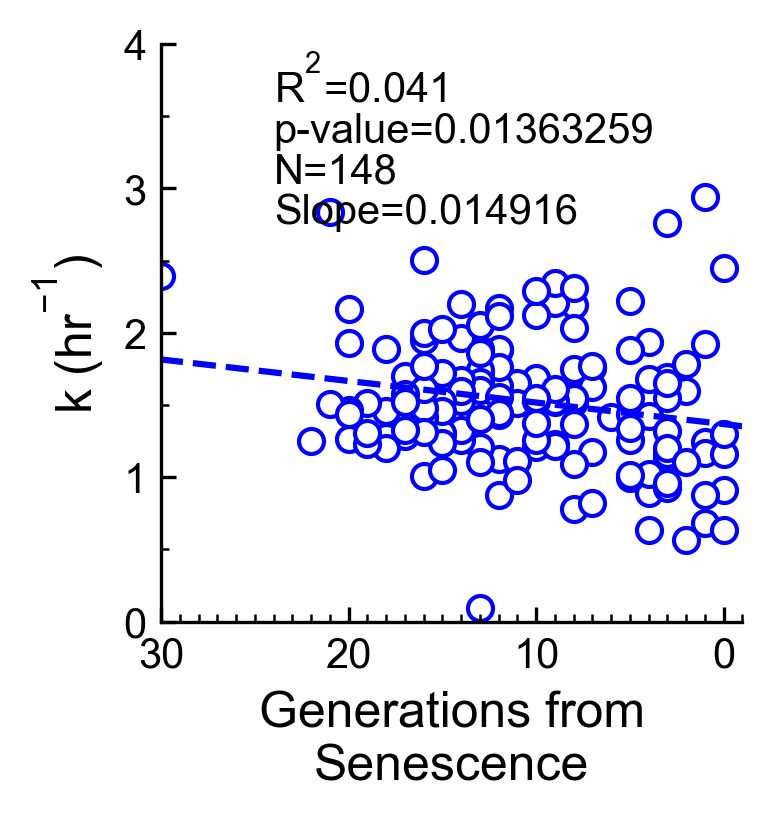

In [66]:
df = fits_table
mdf = mdf
yvar = 'b'
xvar = 'dist_from_sen'
scatterkwargs = {'color': 'white',
                 'edgecolor': 'blue'}
linekwargs = {'color': 'blue',
              'linestyle': '--'}
ylabel = 'k (hr$^{-1}$)'
xlabel = 'Generations from\nSenescence'
compdir = os.path.join(constants.byc_data_dir, mdf.compartment_reldir.unique()[0])
exptdir = os.path.abspath(os.path.join(compdir, '..'))
savepath = os.path.join(compdir, f'{yvar}_vs_{xvar}.svg')
from scipy.stats import linregress
ylim = (0, 4)
xlim = (30, -1)
xminorspace = 1
yminorspace = 0.1
xticks = np.arange(0, xlim[0]+1, 10)
fig = plt.figure(figsize=(2.5, 2.5))
fig.set_dpi(300)

ax = fig.add_subplot(111)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
x = df.loc[:, xvar]
y = df.loc[:, yvar]
ax.scatter(x, y, **scatterkwargs)

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for spine in [ax.spines[key] for key in ['top', 'right']]:
    spine.set_visible(False)
    
ax.set_ylabel(ylabel, fontsize=12)
ax.set_xlabel(xlabel, fontsize=12)

# Plot linear regression
slope, intercept, r, p, se = linregress(x, y)
x_smooth = np.linspace(np.min(xlim), np.max(xlim), 30)
y_pred = ft.line(x_smooth, slope, intercept)
r_sq = r*r
r_sq_term = 'R$^2$'
r_sq_label = f'{r_sq_term}={np.round(r_sq, 3)}'
ax.plot(x_smooth, y_pred, **linekwargs)
rloc = (0.8*np.max(xlim), 0.9*np.max(ylim))
ploc = (0.8*np.max(xlim), 0.83*np.max(ylim))
nloc = (0.8*np.max(xlim), 0.76*np.max(ylim))
sloc = (0.8*np.max(xlim), 0.69*np.max(ylim))
ax.annotate(f'{r_sq_label}', xy=rloc)
ax.annotate(f'p-value={np.round(p, 8)}', xy=ploc)
ax.annotate(f'N={len(y)}', xy=nloc)
ax.annotate(f'Slope={str(slope)[0:8]}', xy=sloc)
plotting.format_ticks(ax, xminorspace=xminorspace)
# ax.annotate(f'slope={np.round(slope, 3)}', xy=sloc)
print(f'N={len(df.loc[:, yvar])}')
fig.savefig(savepath)
print(f'Saved figure at: \n{savepath}')

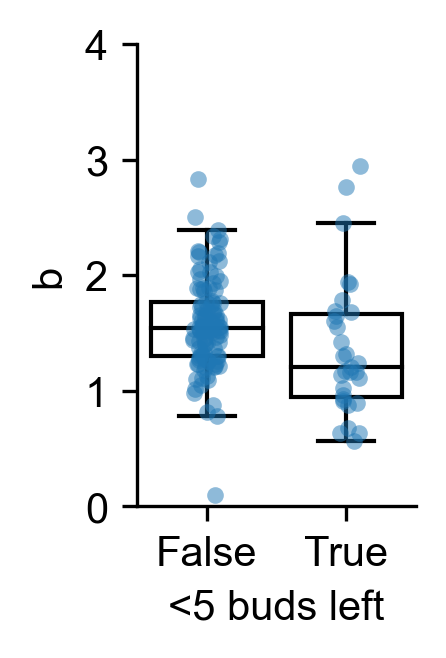

In [67]:
fig, ax = plotting.figure_ax(width_scale=0.6)
cutoff = 5
fits_table.loc[:, f'<{cutoff} buds left'] = np.nan
fits_table.loc[fits_table.dist_from_sen<cutoff, f'<{cutoff} buds left'] = True
fits_table.loc[fits_table.dist_from_sen>cutoff, f'<{cutoff} buds left'] = False

hue_order = np.sort(fits_table.abs_chase_frame.unique())
kwargs = {
    'y': 'b',
    'x': f'<{cutoff} buds left',
    'data': fits_table,
    'ax': ax,
    'dodge': True,
}
sns.boxplot(**kwargs, **plotting.transparent_boxes_prop_dict, showfliers=False)

# from statannotations.Annotator import Annotator
# box_pairs = [
#     (False, True)
# ]
# test = 'Mann-Whitney'
# text_format = 'simple'
# loc = 'inside'
# annotator = Annotator(
#     ax,
#     box_pairs,
#     x=kwargs['data'][kwargs['x']],
#     y=kwargs['data'][kwargs['y']],
#     order=kwargs['order'])
# annotator.configure(test=test, text_format=text_format,
#                     loc=loc, show_test_name=False,
#                     line_width=1, fontsize=7.5,
#                     comparisons_correction="bonferroni")
# annotator.apply_and_annotate()
sns.stripplot(**kwargs, alpha=0.5, linewidth=0, s=4)
# ax.legend(ax.get_legend_handles_labels()[0][4:], ax.get_legend_handles_labels()[1][4:], title='Chase frame', frameon=False, bbox_to_anchor=(1, 1))
ax.set_ylim(0, 4)
fig.set_dpi(300)